In [5]:
import os, gc, torch

import warnings
warnings.filterwarnings("ignore")
import pandas as pd

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer
from pytorch_forecasting.metrics import RMSE, MultiLoss

device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

print(f'Using {device} backend.')

Using cuda backend.


In [6]:
from configurations.config import *
@dataclass
class arguments:
    experiment = 'electricity'
    show_progress = True

config = ExperimentConfig(experiment=arguments.experiment)
formatter = config.data_formatter

In [7]:
df = formatter.read_file()
print(f'Total data shape {df.shape}')

from utils.metric import show_result
from utils.data import create_TimeSeriesDataSet
from utils.model import seed_torch
seed_torch(seed=config.seed)
train, validation, test = formatter.split(df)

parameters = config.model_parameters(ModelType.TFT)
batch_size = parameters['batch_size']
_, train_dataloader = create_TimeSeriesDataSet(
    train, formatter, batch_size, train=True
)
_, val_dataloader = create_TimeSeriesDataSet(validation, formatter, batch_size)
test_timeseries, test_dataloader = create_TimeSeriesDataSet(test, formatter, batch_size)

id DataTypes.CATEGORICAL InputTypes.ID
hours_from_start DataTypes.INTEGER InputTypes.TIME
power_usage DataTypes.FLOAT InputTypes.TARGET
hour DataTypes.INTEGER InputTypes.KNOWN
day_of_week DataTypes.INTEGER InputTypes.KNOWN
categorical_id DataTypes.CATEGORICAL InputTypes.STATIC
Unnamed: 0                   int64
power_usage                float64
t                          float64
days_from_start              int64
categorical_id              object
date                        object
id                          object
hour                         int32
day                          int64
day_of_week                  int32
month                        int64
hours_from_start             int32
categorical_day_of_week      int64
categorical_hour             int64
dtype: object
Total data shape (2198072, 14)


Global seed set to 7


Experimental config found for electricity.
                  Fetching parameters from available models ['tft'].


In [8]:
import tensorflow as tf
# click this and locate the lightning_logs folder path and select that folder. 
# this will load tensorbaord visualization
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=0, 
    patience=parameters['early_stopping_patience']
    , verbose=True, mode="min"
)
best_checkpoint = pl.callbacks.ModelCheckpoint(
    dirpath=config.experiment_folder, monitor="val_loss", 
    filename="best-{epoch}"
)
latest_checkpoint = pl.callbacks.ModelCheckpoint(
    dirpath=config.experiment_folder, 
    every_n_epochs=1, filename="latest-{epoch}"
)

logger = TensorBoardLogger(config.experiment_folder)  # logging results to a tensorboard

# https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-class-api
trainer = pl.Trainer(
    max_epochs = parameters['epochs'],
    accelerator = 'auto',
    enable_model_summary=True,
    callbacks = [early_stop_callback, best_checkpoint, latest_checkpoint],
    logger = logger,
    enable_progress_bar = arguments.show_progress,
    check_val_every_n_epoch = 2,
    max_time=pd.to_timedelta(1, unit='minutes')
)

tft = TemporalFusionTransformer.from_dataset(
    test_timeseries,
    learning_rate= parameters['learning_rate'],
    hidden_size= parameters['hidden_layer_size'],
    attention_head_size=parameters['attention_head_size'],
    dropout=parameters['dropout_rate'],
    loss=MultiLoss([RMSE(reduction='mean') for _ in formatter.targets]), # RMSE(reduction='sqrt-mean')
    optimizer='adam',
    log_interval=1,
    # reduce_on_plateau_patience=2
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 22.0k


In [9]:
from datetime import datetime
gc.collect()

start = datetime.now()
print(f'\n----Training started at {start}----\n')

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)
end = datetime.now()
print(f'\n----Training ended at {end}, elapsed time {end-start}')
print(f'Best model by validation loss saved at {trainer.checkpoint_callback.best_model_path}')


----Training started at 2023-05-06 20:04:51.884721----



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 5.9 K 
3  | prescalers                         | ModuleDict                      | 32    
4  | static_variable_selection          | VariableSelectionNetwork        | 48    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.



----Training ended at 2023-05-06 20:05:55.857300, elapsed time 0:01:03.972579
Best model by validation loss saved at 


In [12]:
from classes.PredictionProcessor import PredictionProcessor

processor = PredictionProcessor(
    formatter.time_index, formatter.group_id, 
    formatter.parameters['horizon'], formatter.targets, 
    formatter.parameters['window']
)

# %%
from classes.Plotter import *

plotter = PlotResults(
   config.experiment_folder, formatter.time_index, 
   formatter.targets, show=arguments.show_progress
)

best_model_path = trainer.checkpoint_callback.best_model_path
print(f'Loading best model from {best_model_path}')

# tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

Loading best model from 


In [ ]:

# print('\n---Training prediction--\n')
# train_predictions, train_index = tft.predict(
#     train_dataloader, return_index=True, 
#     show_progress_bar=arguments.show_progress
# )
# train_result_merged = processor.align_result_with_dataset(
#    train, train_predictions, train_index
# )

# show_result(train_result_merged, formatter.targets)
# plotter.summed_plot(train_result_merged, type='Train_error', plot_error=True)
# gc.collect()

In [13]:
print(f'\n---Validation results--\n')

validation_predictions, validation_index = tft.predict(
    val_dataloader, return_index=True, 
    show_progress_bar=arguments.show_progress
)


---Validation results--



Predict:   0%|          | 0/798 [00:00<?, ? batches/s]

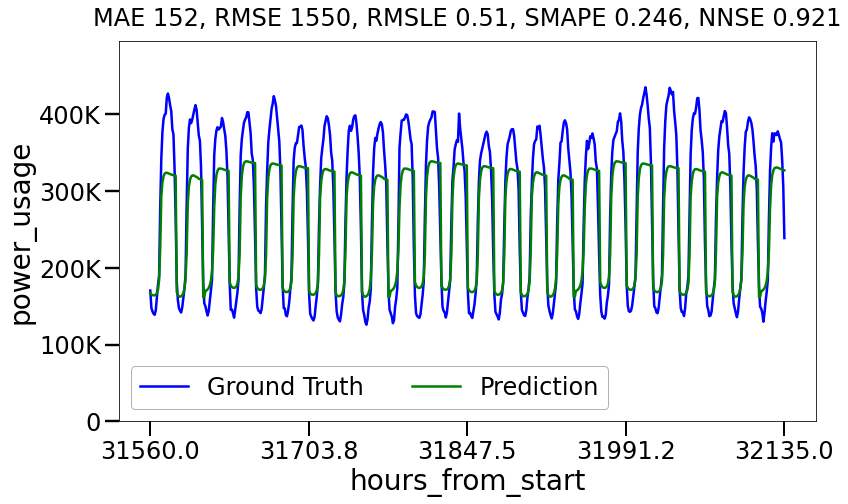

2945

In [62]:
validation_result_merged = processor.align_result_with_dataset(
   validation, validation_predictions, validation_index
)
show_result(validation_result_merged, formatter.targets)

plotter.summed_plot(validation_result_merged, type='Validation')
gc.collect()


---Test results--



Predict:   0%|          | 0/210 [00:00<?, ? batches/s]

Target power_usage, MAE 143.81, RMSE 1292.7, RMSLE 0.49538, SMAPE 0.23831. NNSE 0.94086.



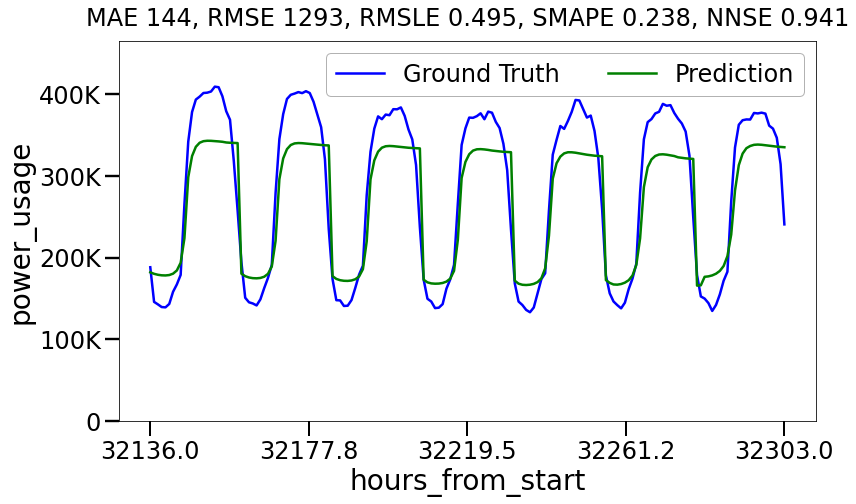

2945

In [63]:
print(f'\n---Test results--\n')

test_predictions, test_index = tft.predict(
    test_dataloader, return_index=True, 
    show_progress_bar=arguments.show_progress
)

test_result_merged = processor.align_result_with_dataset(
    test, test_predictions, test_index
)
show_result(test_result_merged, formatter.targets)
plotter.summed_plot(test_result_merged, 'Test')
gc.collect()

In [2]:
# train_result_merged['split'] = 'train'
validation_result_merged['split'] = 'validation'
test_result_merged['split'] = 'test'
df = pd.concat([validation_result_merged, test_result_merged])
df.to_csv(os.path.join(plotter.figPath, 'predictions.csv'), index=False)

print(f'Ended at {datetime.now()}. Elapsed time {datetime.now() - start}')